In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import copy
import lmdb
# display plots in this notebook
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10, 10) 

# Make sure that caffe is on the python path:
caffe_root = ''  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

In [2]:
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = 'models/deep_mammo/alex_dropout_0_5_deploy.prototxt'
WEIGHTS_FILE = '/mnt/weights/pretrained.2844_iter.alex_reg_0_005_0_5_dropout.caffemodel'
IMAGE_FILE = '/mnt/2x_augmented_train/P_00481_RIGHT_MLO_1_4_0.tif'
MEAN_FILE = '/home/ubuntu/2x_padding_224x224_dataset/mass_2x_padding_dataset_train_mean.binaryproto'
val_lmdb = "/home/ubuntu/2x_padding_224x224_dataset/mass_2x_padding_dataset_val_lmdb"

caffe.set_mode_cpu()

In [3]:
def get_mean_image():
    mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
    f = open(MEAN_FILE, 'rb')
    mean_blobproto_new.ParseFromString(f.read())
    mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
    f.close()
    return mean_image

In [4]:
def get_val_images(n=10):
    lmdb_env = lmdb.open(val_lmdb)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    X, y = [], []
    i = 0
    for key, value in lmdb_cursor:
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
        image = caffe.io.datum_to_array(datum)
        image = image.astype(np.uint8)
        X.append(image)
        y.append(label)
        i += 1
        if i == n:
            break
    
    return np.array(X), np.array(y)

In [5]:
X, y = get_val_images()
print X.shape
print y

(10, 3, 224, 224)
[0 0 1 1 0 0 1 1 1 1]


In [6]:
# input_image = caffe.io.load_image(IMAGE_FILE)
# plt.imshow(input_image)
mean_image = get_mean_image()
# # input_image = np.expand_dims(np.transpose(input_image, (2, 0, 1)), axis=0)
# input_image = np.transpose(input_image, (2, 1, 0))

net = caffe.Net(MODEL_FILE, WEIGHTS_FILE, caffe.TEST)
caffeLabel = np.zeros_like(net.blobs['prob'].data)
caffeLabel[np.arange(caffeLabel.shape[0]), y] = 1
print caffeLabel
out = net.forward_all(data=X - mean_image)
print net.blobs['prob'].diff.shape
print net.blobs['prob'].diff
print net.blobs['prob'].data.shape
print net.blobs['prob'].data
diffs = net.backward(**{net.outputs[0]: caffeLabel})
dX = diffs['data']
print dX.shape

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
(10, 2)
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
(10, 2)
[[  4.35571633e-02   9.56442833e-01]
 [  8.79545391e-01   1.20454609e-01]
 [  2.32028984e-03   9.97679770e-01]
 [  3.04412388e-04   9.99695659e-01]
 [  9.98912573e-01   1.08748593e-03]
 [  7.37296343e-01   2.62703687e-01]
 [  8.07723496e-03   9.91922736e-01]
 [  4.45740483e-07   9.99999523e-01]
 [  9.91127687e-04   9.99008894e-01]
 [  8.57856333e-01   1.42143682e-01]]
(10, 3, 224, 224)


(224, 224, 3)


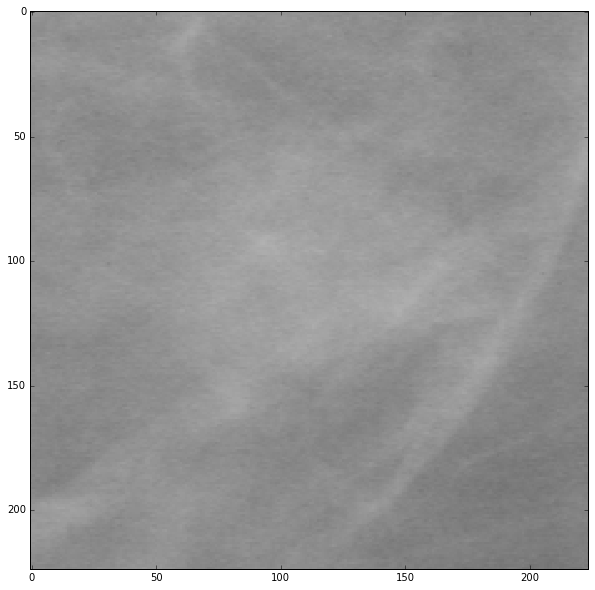

In [11]:
img = X[0]
img = img
print img.shape
plt.imshow(img)

In [18]:
saliency = np.amax(np.abs(dX), axis=1)
class_names = {1: 'Malignant', 0: 'Benign'}

In [34]:
def show_saliency_maps(X, y, saliency, name):
    n = X.shape[0]
    for i in xrange(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, n, n + i + 1)
        plt.imshow(saliency[i])
        plt.axis('off')
    plt.gcf().set_size_inches(10, 4)
    plt.savefig(name)
    plt.show()

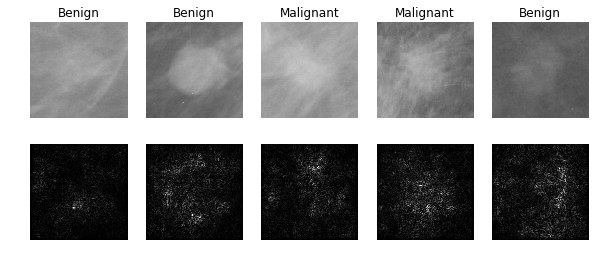

In [35]:
show_saliency_maps(X[:5], y[:5], saliency[:5], 'saliency1.png')

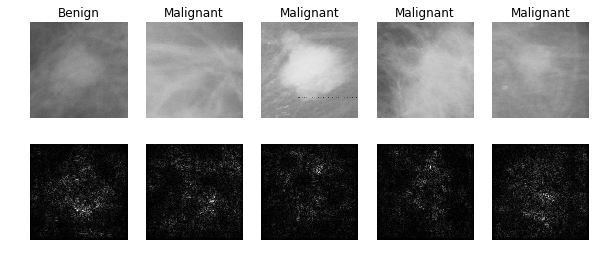

In [36]:
show_saliency_maps(X[5:], y[5:], saliency[5:], 'saliency2.png')